![Альтернативный текст](https://github.com/DIVIGL1/RSSchool-ML-Open-Course/blob/main/3_linear_regression/LRPict.png?raw=true "Это инопланетянин!")

## Linear regression

This assignment is dedicated to Linear regression. 12 task, 30 points max.

By focusing on predicting different features of football players,
you will:
* gain understanding of mathematics behind Linear Regression model
* and become familiar with using `sklearn` library for solving this kind of tasks

In the assignment we will:
* build Linear regression models with 1 and many variables
* use both library methods and manual calculations using mathematical formulas
* implement main regression metrics to evaluate performance of our models
* explore limitations of classical linear regression

### Notes:
* do not modify `assert` blocks in code. They are used to check your results
    

### Data
- In this notebook we will work with Football Player attributes per each match played.
  
  Data is taken from [European Soccer Database](https://www.kaggle.com/hugomathien/soccer) dataset. 
  
  The table used is `Player_Attributes`.


### Materias

Start with the assignment first. Use materials below as references when needed.

* NumPy:
    - [quickstart](https://numpy.org/doc/stable/user/quickstart.html)
    - [api reference](https://numpy.org/doc/stable/reference/index.html)
    

* Pandas:
    - [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html)
    - guide on [groupby.transform](https://pandas.pydata.org/docs/user_guide/groupby.html#transformation). 
      used in one of tasks on data preprocessing
    - [cheat sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
    

* sklearn:
    - [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) class documentation
    - guide on [Linear models](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)


* Matplotlib:
    - [cheatsheet](https://matplotlib.org/cheatsheets/)
    - examples of [main plot types](https://matplotlib.org/stable/plot_types/index.html)
    - [scatter plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) documentation

In [1]:
import os

import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = 'raise'  # forbid chained assignment to prevent implicit errors

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 6)  # set default figure size

import seaborn as sns
sns.set(font_scale=1.1)  # increase default font scale and set seaborn's plot style

from typing import List, Iterable

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Processing

In [3]:
data_root_dp = "" #os.path.join('..', '..', 'data', 'soccer')  # change to yours path
print(f'data_root_dp: "{data_root_dp}"')

data_root_dp: ""


*****
### `КОММЕНТАРИЙ`
Не стал мудрить с размещением данных и расположил их в той же папке что и ноутбук.
*****

### read the raw SQL data
* you can run this code only once.<br>
  it will read `.sqlite` file and save extracted data to a more handy `.csv` format

In [4]:
# import sqlite3

# # open connection to .sqlite file
# data_sql_fp = 'database.sqlite' #os.path.join(data_root_dp, 'database.sqlite')
# print(f'will read from: "{data_sql_fp}"')
# con = sqlite3.connect(data_sql_fp)

# df = pd.read_sql('select * from Player_Attributes', con)  # run SQL-query
# print(f'shape: {df.shape}')
# con.close()  # close connection to .sqlite file

# # save to .csv
# out_fp = 'player_attributes.csv' # os.path.join(data_root_dp, '', 'player_attributes.csv')
# # os.makedirs(os.path.dirname(out_fp), exist_ok=True)  # create directories if needed
# print(f'will save to: "{out_fp}"')
# df.to_csv(out_fp, index=False)

### read the  data

In [5]:
data_player_attributes_fp = os.path.join(data_root_dp, 'player_attributes.csv')
print(f'reading from: "{data_player_attributes_fp}"')
df = pd.read_csv(data_player_attributes_fp)
print(df.shape)

reading from: "player_attributes.csv"
(183978, 42)


In [6]:
df.dtypes

id                       int64
player_fifa_api_id       int64
player_api_id            int64
date                    object
overall_rating         float64
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision  

### basic data processing

In [7]:
# there are 3 'id' columns in data. 
# we will use 'player_api_id' only
# and drop other 'id' columns.
redundant_key_columns = ['id', 'player_fifa_api_id']

# also we will drop categorical columns for this task.
categorical_columns = ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']

cols_to_drop = redundant_key_columns + categorical_columns
print(f'will drop following columns: {cols_to_drop}')
df.drop(columns=cols_to_drop, inplace=True)

# rename 'player_api_id' column to shorter one: 'id'.
df.rename(columns={'player_api_id': 'id'}, inplace=True)

# cast string values to datetime
df['date'] = pd.to_datetime(df['date'])

# drop records that contain only NaNs in features
all_features = set(df.columns).difference(['id', 'date'])  # all columns without key columns
df.dropna(subset=all_features, how='all', inplace=True)

print(f'df.shape: {df.shape}')

will drop following columns: ['id', 'player_fifa_api_id', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate']
df.shape: (183142, 37)


In [8]:
# the dataset we're working with migh get updated in future (new records might be added).
# thus we remove any records with date larger than the current max date in data (2016-07-07)
# for compatibility with current version of notebook.
df.drop(index=df[df['date'] > '2016-07-07'].index, inplace=True)
print(df.shape)

(183142, 37)


### drop duplicates

* we should **ALWAYS** understand what our data represents


* here we are dealing with Football Player attributes per each match played.

  so we expect the data to have `(id, date)` as a key
  
  
* let's check whether our assumption holds

In [9]:
df.duplicated(['id', 'date']).value_counts()

False    183142
dtype: int64

* there are no duplicates if considering `(id, date)` pair as a key

*****
### `КОММЕНТАРИЙ`
#### Запомним этот момент! Он означет, что будет верным высказывание: для каждого `id` существует только одна запись с максимальной датой.
*****


In [10]:
df.duplicated('id').value_counts()

True     172082
False     11060
dtype: int64

* and there are duplicates if considering only `id` column as a key

* so our assumption holds. but let's work only with latest stats for each player

*****
### `КОММЕНТАРИЙ`
#### То есть `id` здесь не является первичным ключом и не уникально.
*****


In [11]:
df

id       date  overall_rating  potential  crossing  finishing  \
0       505942 2016-02-18            67.0       71.0      49.0       44.0   
1       505942 2015-11-19            67.0       71.0      49.0       44.0   
2       505942 2015-09-21            62.0       66.0      49.0       44.0   
3       505942 2015-03-20            61.0       65.0      48.0       43.0   
4       505942 2007-02-22            61.0       65.0      48.0       43.0   
...        ...        ...             ...        ...       ...        ...   
183973   39902 2009-08-30            83.0       85.0      84.0       77.0   
183974   39902 2009-02-22            78.0       80.0      74.0       76.0   
183975   39902 2008-08-30            77.0       80.0      74.0       71.0   
183976   39902 2007-08-30            78.0       81.0      74.0       64.0   
183977   39902 2007-02-22            80.0       81.0      74.0       68.0   

        heading_accuracy  short_passing  volleys  dribbling  curve  \
0                   71.0           61.0     44.0       51.0   45.0   
1                   71.0           61.0     44.0       51.0   45.0   
2                   71.0           61.0     44.0       51.0   45.0   
3                   70.0           60.0     43.0       50.0   44.0   
4                   70.0           60.0     43.0       50.0   44.0   
...                  ...            ...      ...        ...    ...   
183973              59.0           89.0     77.0       84.0   86.0   
183974              53.0           84.0     77.0       85.0   86.0   
183975              53.0           84.0     77.0       85.0   86.0   
183976              57.0           86.0     77.0       87.0   86.0   
183977              57.0           88.0     77.0       87.0   86.0   

        free_kick_accuracy  long_passing  ball_control  acceleration  \
0                     39.0          64.0          49.0          60.0   
1                     39.0          64.0          49.0          60.0   
2                     39.0          64.0          49.0          60.0   
3                     38.0          63.0          48.0          60.0   
4                     38.0          63.0          48.0          60.0   
...                    ...           ...           ...           ...   
183973                78.0          84.0          85.0          66.0   
183974                74.0          73.0          86.0          66.0   
183975                74.0          73.0          86.0          66.0   
183976                73.0          73.0          91.0          61.0   
183977                53.0          78.0          91.0          58.0   

        sprint_speed  agility  reactions  balance  shot_power  jumping  \
0               64.0     59.0       47.0     65.0        55.0     58.0   
1               64.0     59.0       47.0     65.0        55.0     58.0   
2               64.0     59.0       47.0     65.0        55.0     58.0   
3               64.0     59.0       46.0     65.0        54.0     58.0   
4               64.0     59.0       46.0     65.0        54.0     58.0   
...              ...      ...        ...      ...         ...      ...   
183973          72.0     77.0       86.0     73.0        76.0     58.0   
183974          67.0     77.0       74.0     73.0        75.0     58.0   
183975          67.0     77.0       74.0     73.0        75.0     58.0   
183976          60.0     77.0       69.0     73.0        72.0     58.0   
183977          64.0     77.0       66.0     73.0        72.0     58.0   

        stamina  strength  long_shots  aggression  interceptions  positioning  \
0          54.0      76.0        35.0        71.0           70.0         45.0   
1          54.0      76.0        35.0        71.0           70.0         45.0   
2          54.0      76.0        35.0        63.0           41.0         45.0   
3          54.0      76.0        34.0        62.0           40.0         44.0   
4          54.0      76.0        34.0        62.0           40.0         44.0   
...   

#### Task 1. Keep only latest data for each player (1 point)

* HINT: you can use 

  `df[<new_column>] = df.groupby(<key_to_aggregate>)[<column>].transform('max')` 
  
  to get the `max` value of `<column>` for each group specified by `<key_to_aggregate>` columns.
  
  then you'll have to filter rows using `<column>` and `<new_column>` values
  

* don't forget to remove any additional columns you introduce here

In [12]:
# # your code here
df_save = df.copy(deep=True)

df_save["max_date"] = df_save.groupby("id")["date"].transform('max')
df_save = df_save[df_save["max_date"]==df_save["date"]] # это тоже самое, что и df.drop(...), только понятнее.

df = df_save.drop(columns='max_date')
del df_save

print(df.shape)

(11060, 37)


*****
### `КОММЕНТАРИЙ`
### Уточнение для предыдущей ячейки
Можем ли мы быть уверенными, что отбор записей с условием "дата равна макимальной дате" гарантирует, что для одного игрока не попадутся две записи с одинаковым id и датой? Вывод сделанный раньше (для каждого id существует только одна запись с максиальной датой) гарантирует, что дублей не будет!

Так же отметим, что число строк `11060` совпало с числом уникальных, выявленных в одной из ячеек выше (там где выполняется команда `df.duplicated('id').value_counts()`)

Теперь у нас `id` - это первичный ключ.
*****


In [13]:
assert df.duplicated(['id']).sum() == 0
assert df.shape == (11060, 37)

In [14]:
# no longer need 'id' and 'date' columns
df.drop(columns=['id', 'date'], inplace=True)

### NaNs

In [15]:
df.isna().sum()

overall_rating          0
potential               0
crossing                0
finishing               0
heading_accuracy        0
short_passing           0
volleys               478
dribbling               0
curve                 478
free_kick_accuracy      0
long_passing            0
ball_control            0
acceleration            0
sprint_speed            0
agility               478
reactions               0
balance               478
shot_power              0
jumping               478
stamina                 0
strength                0
long_shots              0
aggression              0
interceptions           0
positioning             0
vision                478
penalties               0
marking                 0
standing_tackle         0
sliding_tackle        478
gk_diving               0
gk_handling             0
gk_kicking              0
gk_positioning          0
gk_reflexes             0
dtype: int64

* do you see any pattern in how NaNs are distributed?

*****
### `КОММЕНТАРИЙ`
Напрашивается, мысль о том что ВСЕ пропущенные данные находятся в одних и тех же строках, а не разбросаны по датасету. Проверим и убедимся, что так и есть:
*****


In [16]:
# Ориентируясь на один столбец, выберем строки где у нём "na" и посомтрим, что в остальных:
df[df.volleys.isna()][["agility", "curve", "agility", "balance", "jumping", "vision", "sliding_tackle"]].isna().sum()

agility           478
curve             478
agility           478
balance           478
jumping           478
vision            478
sliding_tackle    478
dtype: int64

*****
### `КОММЕНТАРИЙ`
Результат выведенной в предыдущая ячейке информации подтверждает, что ВСЕ пропущенные данные находятся в одних и тех же строках, которых всего `478`.
*****


In [17]:
df.isna().sum(axis=1).value_counts()

0    10582
7      478
dtype: int64

#### Task 2. Drop rows that contain NaNs (1 point)

In [18]:
# your code here
df = df[df.volleys.notna()]

# Можно было бы и грубо: df = df.dropna(), результат был бы тот же

In [19]:
assert df.isna().sum().sum() == 0

In [20]:
print(df.shape)

(10582, 35)


## Task 3. Implement main regression metrics yourself (up to 4 points):
* Mean Squared Error (mse) - **(1 point)**
* Mean Absolute Error (mae) - **(1 point)**
* Mean Absolute Percentage Error (mape) - **(1 point)**
* R-squared (r2) - **(1 point)**


#### bonus point: MAPE is implemented in such way to take possible 0 in `y_true` into account
Hints:

* you should divide on 
  $ \hat{y}_{true} = (\hat{y}_{true}^{(0)}, \hat{y}_{true}^{(1)}, ..., \hat{y}_{true}^{(n)}) $,
  
  where $ \ \ \hat{y}_{true}^{(i)} = max(\ \ | y_{true}^{(i)} |, \ \ \epsilon), \ \ \epsilon > 0, \ \ y_{true}^{(i)} \in \mathbb R $
  

* for compatibility with `sklearn` take 

  `eps = np.finfo(np.float64).eps`
  
  
#### bonus point: $R^2$ is implemented in such way to take possible 0 in numerator and denominator into account
Hints:

* recall the formula: $ R^2 = 1 - \dfrac{SS_{residuals}}{SS_{total}} $


* you should return:

    $
    \begin{cases}
     R^2 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} \ne 0 
     \\
     0 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} = 0 
     \\
     1 & \text { otherwise }
    \end{cases}
    $
    

* for a better understanding of $R^2$ coefficient 
  try to explain to yourself why we return those values in each of edge cases

In [21]:
# we use '*' in the beggining of each function signature
# to forbid positional arguments and enforce the use of kwargs.
# this helps to avoid mistake when arguments are passed in wrong order.

# write down code instead of raising NotImplementedError in each of functions below.

def mse(*, y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_mse = y_true - y_pred
    y_mse **= 2
    return(np.sum(y_mse) / len(y_mse))
    
def mae(*, y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_mse = np.abs(y_true - y_pred)
    return(np.sum(y_mse) / len(y_mse))
    
def mape(*, y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_divide = y_true.copy()
    y_divide[y_divide == 0] = np.finfo(np.float64).eps
    return(np.sum(np.abs((y_true - y_pred) / y_divide))) / len(y_true)
    
def r2(*, y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    SS_res = np.sum((y_true - y_pred)**2)
    SS_tot = np.sum((y_true - np.mean(y_true))**2)
    if (SS_res != 0 and SS_tot != 0):
        return ( 1 - (SS_res / SS_tot) )
    elif (SS_res != 0 and SS_tot == 0):
        return 0
    else:
        return 1


*****
### `КОММЕНТАРИЙ`
На самом деле можно не заниматься заменой нулевых значений на минимальное число в y_true, а просто прибавить самое маленькое число (np.finfo(np.float64).eps) к обоим y_true и y_pred, а формула при этом случае остаётся исходной. Результат будет тот же самый (правильный) - **проверено!**
*****


### Validate your implementations are correct

* we'll use synthetic data for this task


In [22]:
from sklearn.metrics import (
    mean_squared_error as mse_lib, 
    mean_absolute_error as mae_lib,
    mean_absolute_percentage_error as mape_lib,
    r2_score as r2_lib
)

In [23]:
def compare_metrics(fn, fn_lib, y_true, y_pred, n_digits=9):
    """ Print and compare values of custom and library functions using given precision. """
    m_fn = fn(y_true=y_true, y_pred=y_pred)
    m_fn_lib = fn_lib(y_true=y_true, y_pred=y_pred)
    print(f'{fn.__name__} custom : {m_fn}')
    print(f'{fn.__name__} library: {m_fn_lib}')
    print()
    assert round(m_fn, n_digits) == round(m_fn_lib, n_digits)

#### a case with a good fit

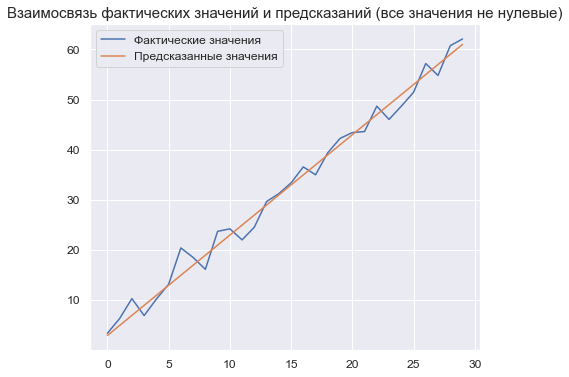

In [24]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = 2 * x + 3

plt.plot(x, y_true, label='Фактические значения')
plt.plot(x, y_pred, label='Предсказанные значения')
plt.title("Взаимосвязь фактических значений и предсказаний (все значения не нулевые)", fontsize=15)
plt.legend();

In [25]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 4.195220885862038
mse library: 4.195220885862038

mae custom : 1.7163134200785193
mae library: 1.7163134200785193

mape custom : 0.08326048516623472
mape library: 0.08326048516623472

r2 custom : 0.9855744193211918
r2 library: 0.9855744193211918

all tests passed


#### 0s in target. MAPE should explode

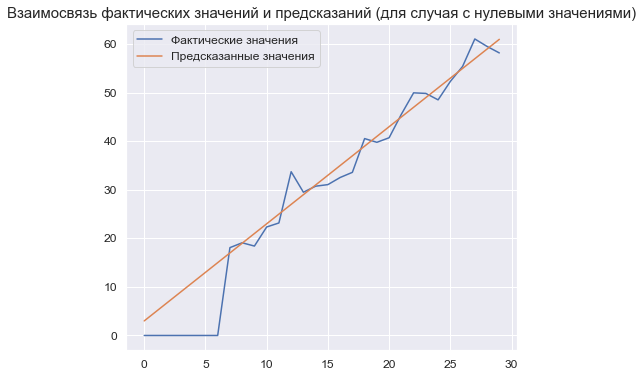

In [26]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_true[:7] = 0
y_pred = 2 * x + 3

plt.plot(x, y_true, label='Фактические значения')
plt.plot(x, y_pred, label='Предсказанные значения')
plt.title("Взаимосвязь фактических значений и предсказаний (для случая с нулевыми значениями)", fontsize=15)
plt.legend();

In [27]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 26.933386180636507
mse library: 26.933386180636507

mae custom : 3.497909983532506
mae library: 3.497909983532506

mape custom : 9457559217478042.0
mape library: 9457559217478042.0

r2 custom : 0.9343769614247497
r2 library: 0.9343769614247497

all tests passed


*****
### `КОММЕНТАРИЙ`
Предложенная пользовательская формула для вычисления метрики `mse` корректно работает и при наличии нулевых значений.
*****


#### edge cases for R2

In [28]:
# constant target value

n = 30
x = np.arange(n)
y_true = np.repeat(15, n)
y_pred = 2 * x + 3

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 0
r2 library: 0.0

success


In [29]:
# perfect fit

n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = y_true

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 1
r2 library: 1.0

success


*****
### `КОММЕНТАРИЙ`
Предложенная пользовательская формула для вычисления метрики `r2` корректно работает для всех рассмотренных случаев.
*****


### Define helper functions

In [30]:
def get_metrics(*, y_true, y_pred) -> pd.Series:
    """ A helper function to return all metrics for given labels and predictions. """
    
    # if you didn't implement some metrics, comment them out for this function to work.
    return pd.Series({
        'mse': mse(y_true=y_true, y_pred=y_pred),
        'mae': mae(y_true=y_true, y_pred=y_pred),
        'mape': mape(y_true=y_true, y_pred=y_pred),
        'r2': r2(y_true=y_true, y_pred=y_pred),
    })

In [31]:
def fit_and_evaluate(model, x_train, y_train, x_test, y_test) -> pd.DataFrame:
    """ 
    A helper function to: 
    * fit a passed model
    * and return metrics on train and test sets.
    """
    # fit the model
    model.fit(x_train, y_train)
    
    # return metrics as pd.DataFrame
    m = pd.DataFrame([
        get_metrics(y_true=y_train, y_pred=model.predict(x_train)),  # metrics for train set
        get_metrics(y_true=y_test, y_pred=model.predict(x_test))     # metrics for test set
    ], index=['train', 'test']
    )
    
    return m

## train/test split

* Split the data we have into Train and Test splits with 80%/20% proportion

In [32]:
print(df.shape)
ix_split = int(0.8 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(DF_TRAIN.shape, DF_TEST.shape)

(10582, 35)
(8465, 35) (2117, 35)


*****
### `КОММЕНТАРИЙ`
### Надо понимать, что мы делим наши данные на две части, которые будут использоваться как: 
* данные для тренировки модели;
* данные для оценки модели на точность её предсказания.

#### Здесь мы определяем, что в качестве тренировочного датасета у нас будут первые 80% строк от исходных данных, а остальные строки будут использованы для оценки качества прогноза модели. Иногда используют другие пропорции, например, 70% и 30%.
*****


In [33]:
def get_train_test_data(features: List[str], target: str) -> tuple:
    """
    Return x_train, y_train, x_test, y_test using 
    * global train/test split 
    * features and target provided.
    """
    # in general, it's a bad practice to use global variables. 
    # however, we use it here with caution for simplicity.
    return (
        DF_TRAIN[features].copy(), DF_TRAIN[target].copy(), 
        DF_TEST[features].copy(), DF_TEST[target].copy()
    )

*****
### `КОММЕНТАРИЙ`
### Параметры выше определённой функции.
* `features` в этой функции - это список наименований столбцов, которые будут использованы для построения (обсчёта) модели;
* `target` - это целевой параметр, название столбца, который использован как "учитель".
*****


## Linear regression with 1 variable

* Let's start with Linear Regression that predicts target variable 
  using only 1 predictor (independent variable)  

* We will try to predict `dribbling` variable using `short_passing` as a predictor

In [34]:
target = 'dribbling'
features = ['short_passing']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

### Let's visualize our data first

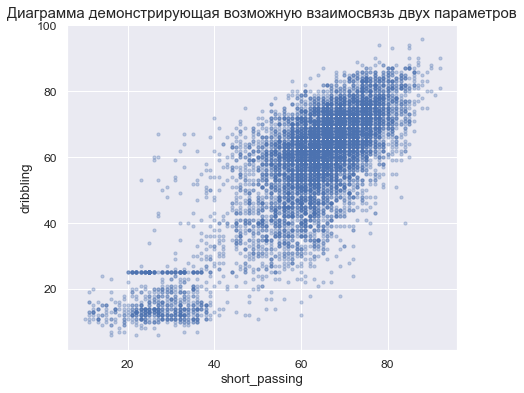

In [35]:
plt.scatter(x=x_train, y=y_train, alpha=0.3, s=10);
plt.xlabel('short_passing')
plt.ylabel('dribbling')
plt.title("Диаграмма демонстрирующая возможную взаимосвязь двух параметров", fontsize=15);

* do you notice anything interesting on this plot?
* if so, how can we use it later to generate more accurate predictions?

*****
### `КОММЕНТАРИЙ`
### Мы видим, что:
* прослеживается линейная зависимость между двумя выбранными параметрами;
* зависимость "восходящая" (от нуля вправо и вверх);
* есть две зоны где линейная зависимость выражена наиболее отчётливо;
* присутствует зона в "середине данных" (там где значение short_passing находится приблизительно в диапазоне между 40 и 45), в которой зависимоть так же присутствует, но данных здесь заметно меньше.


Используя эту информацию, а также предложение о том что в остальных данных (в том числе и в тестовом датасете) распределение параметров будет таким же, то можно говорить о том, что зависимость близкая к линейной на остальных данных так же сохранится. Осталось определить функцию и её параметры, которая выразит эту зависимость. Самая простая модель - линейная, а это означает необходимость определения двух коэффициентов (A и B) в уравнении Y = A * X + B.

#### В отношении коэффициентов (A и B) линейной функции исходя из предвставленной выше диаграмы, визуально, можно сделать следующие предположения:
* коэффициент A близок к 1;
* коэффициент B меньше нуля, так как в точке X=0 Y, видимо, будет отрицательным ("на глаз" около минус 10).
*****


### Task 4. Compute Pearson correlation coefficient between feature and target (1 pont)
Hint: you can use either `pd.Series.corr` method or `np.corrcoef` function

In [36]:
# your code here
corr1 = np.corrcoef(df.short_passing.to_list(), df.dribbling.to_list())
corr1

array([[1.        , 0.81293756],
       [0.81293756, 1.        ]])

*****
### `КОММЕНТАРИЙ`
* features  - это `short_passing`
* target - это `dribbling`

Коэффициент корреляции Пирсона показывает значительную зависимость двух параметров.

PS: Для двух параметров строить heatmap нет смысла.

PPS: Из документации: numpy.corrcoef returns **`Pearson`** product-moment correlation coefficients.

*****
### `УТОЧНЕНИЕ`
Формально, в этом задании нет расшифровки о том какой набор данных необходимо использовать для рассчета `коэффициент корреляции Пирсона` - можно использовать и исходный датасет и тестовый. Что бы эта неточность в задании не оказалась причиной снижения на 1 балл :-) приведём ниже рассчет коэффициента корреляции Пирсона на основании "вырезки" - тестовых данных.
*****


In [37]:
# your code here
corr2 = np.corrcoef(x_train.short_passing, y_train)
corr2

array([[1.        , 0.80940485],
       [0.80940485, 1.        ]])

### Solve using `sklearn`

* we will use `LinearRegression` class from `sklearn` library 
  to fit a linear regression model and use it to generate prediction

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [40]:
model_intercept = model.intercept_
model_slope = model.coef_[0]
print(f'model_intercept: {model_intercept}')
print(f'model_slope: {model_slope}')

model_intercept: -6.211029905026159
model_slope: 1.0366141627766268


*****
### `КОММЕНТАРИЙ`
#### Видим, что высказанное ранее предположение о коэффициентах A и B подтвердились (A близок к 1, а B около минус 10).
*****


* use fitted model to get predictions for test set

In [41]:
model_preds = model.predict(x_test)
model_preds

array([55.98581986, 65.31534733, 44.58306407, ..., 62.20550484,
       54.9492057 , 76.71810312])

* explore model quality on test set.

In [42]:
print('model metrics on test set')
metrics_test_1 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_1

model metrics on test set


mse     108.345801
mae       8.173553
mape      0.205500
r2        0.681477
dtype: float64

* can you explain what those metic values mean?

*****
### `КОММЕНТАРИЙ`

### Попробуем проинтерпретировать значения метрик (выше), получанных с примерением предсказательной модели на тестовой выборке.

#### MSE: mean squared error (среднеквадратическая ошибка)
В формуле для MSE квадраты остатков в числителе применяются для того, чтобы плюсы и минусы не взаимоуничтожились. Физического смысла MSE не имеет, но чем ближе к нулю, тем модель лучше.

#### MAE: mean absolute error (средний модуль отклонения)
Метрика измеряет среднюю сумму абсолютной разницы между фактическим значением и прогнозируемым значением. То есть в нашем случае в среднем ошибка модели "скачет" на +/- 8.17. Так как у нас значения исходных параметров в основном в диапазоне от 20 до 80, то, наверное, это довольно большой разброс (но это с чем сравнивать!).

#### MAPE: mean percentage absolute error (средняя абсолютная ошибка в процентах - что бы перевести в % надо умножить на 100)
В нашем случае означает, что модель в среднем может ошибаться на 20,6%

#### R2: coefficient of determination (коэффициент детерминации)
Характеризует степень сходства исходных данных и предсказанных. В отличие от MSE не зависит от единиц измерения данных, поэтому поддается сравнению. Коэффициент детерминации — важный критерий выбора модели. И если модель плохо коррелирует с исходными данными, она вряд ли будет иметь высокую предсказательную силу.
*****


#### Task 5. Calculate predictions for test set manually (1 point)

Above we used `LinearRegression.predict()` method to obtain predictions. 
Now let's do it manually!

Recall Linear Regression formula:

* $ \hat{y} = w_0 + w_1 \cdot x, $ 

    where:
    * $w_0$ is an intercept
    * $w_1$ is a slope
    * $x$ is a predictor
    * $\hat{y}$ is a predicted variable
  

* use intercept and slope values from fitted LinearRegression model

In [43]:
# use `x_test` for calculations as is (it's a DataFrame with 1 column).
# do not convert it to Series or numpy array.

# your code here:
model_manual_preds = x_test * model_slope + model_intercept

*****
### `КОММЕНТАРИЙ`
### В предыдущей ячейке просто отработали по формуле Y = A * X + B, где:
* **A** - это `model_slope`
* **B** - это `model_intercept`
* **X** - это наш тестовый датасет `x_test`
*****


In [44]:
assert isinstance(model_manual_preds, pd.DataFrame)

In [45]:
# ensure our manual predictions are the same as model generated
assert np.allclose(model_preds, model_manual_preds.iloc[:, 0].to_numpy())
print('success')

success


#### Task 6. Plot test data and predicted values (1 point)

* use `plt.scatter` function as in example above.
* first build scatter plot for test data
* then build scatter plot with model predictions
* add plot title, axis names and legend

Hints:
* use `alpha` parameter to control opacity and `s` parameter to control size of points.
  this will make plot more readable
* use `label` parameter to add label to each set of points added to scatter plot
* use different color for model predictions. control with parameter `color`

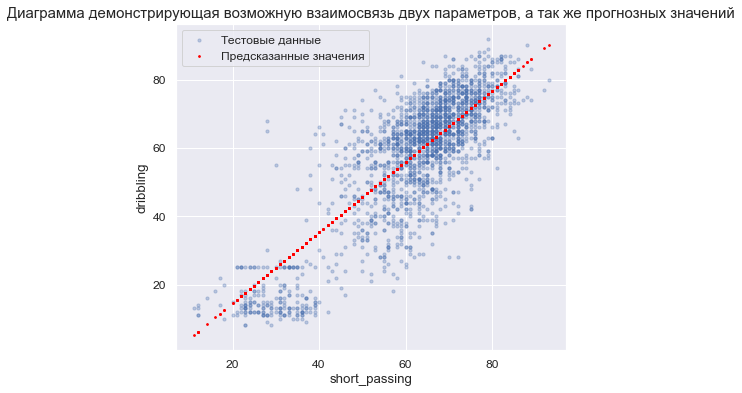

In [46]:
# # your code here
plt.scatter(x = x_test, y = y_test, alpha=0.3, s=10)
plt.scatter(x = x_test, y = model_preds, s=3, color="red")

plt.legend(['Тестовые данные', "Предсказанные значения"], loc="upper left"); # adds legend to a plot
plt.xlabel('short_passing')
plt.ylabel('dribbling')
plt.title("Диаграмма демонстрирующая возможную взаимосвязь двух параметров, а так же прогнозных значений", fontsize=15);

*****
### `КОММЕНТАРИЙ`
Диаграмма отражает то, что у нас получилось:
* синим: тестовый набор данных, который используем для оценки работы сформированной модели;
* красным: прогноз (предсказанные значения), полученный на основании сформированной модели.

Как и следовало ожидать, линейная модель, выдаёт прогноз в виде линии.
*****


### Task 7.  Fit regression model manually (3 points)

So far we have used `sklearn` library to fit linear regression model and obtain predictions. Good job!

Recall the formula of Linear regression for 1 variable:

* $ \hat{y} = w_0 + w_1 \cdot x $

Now let's try to fit the model **ourselves**.

### Theory

Assume our dataset consists of _n_ samples.

To fit a Linear regression model means to find the best set of parameters - 
$(w_0, w_1)$ that minimizes a **Loss function**.<br>
In case of Linear regression we choose **Residual sum of squares (RSS)** as a Loss function:

* $ L(w, x, y) = RSS(w, x, y) = \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

That is conceptually the same as minimizing Mean squared error (MSE):

* $ MSE(w, x, y) = \dfrac{1}{n} \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

Here:
* $y = (y_0, y_2, ..., y_{n-1}) $ - is a vector of target values we want to predict.
  1 value per each sample in our dataset that consists of _n_ samples
* $\hat{y} = (\hat{y}_0, \hat{y}_2, ..., \hat{y}_{n-1}) $ - is a vector of predictions 
* $\hat{y}_i = w_0 + w_1 \cdot x_i$ - is an individual prediction for _i_-th sample in a dataset

---

Best parameters $w_0$ and $w_1$ can be found using **following formulas**:

* $w_0 = \bar{y} - w_1 \cdot \bar{x}$


* $w_1 = \dfrac{\sum_{i=0}^{n-1}(x_i - \bar{x}) y_i}{\sum_{i=0}^{n-1}(x_i - \bar{x})^2}$


* where:
 * $\bar{x} = \dfrac{1}{n} \sum_{i=0}^{n-1}x_i$ - is the mean of vector $x$
 
 * $\bar{y} = \dfrac{1}{n} \sum_{i=0}^{n-1}y_i$ - is the mean of vector $y$
 
You should use these formulas to find the best model parameters in this task.
 
---

If you want to learn more you can refer to 
[Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) wiki-page.

It contains analagous formula for $w_1$ coefficient that is conceptually the same 
(so it's not a bug in our formula provided above).

### Implementation

* convert pd.DataFrame and pd.Series (`x_train` and `y_train` respecitvely) to numpy-arrays

In [47]:
x = x_train.iloc[:, 0].to_numpy()
y = y_train.to_numpy()

* calculate model parameters ($w_1$ - slope and $w_0$ - intercept) using formulas given above

In [48]:
# # your code here:
manual_slope = sum((x - x.mean()) * y) / sum((x - x.mean())**2)
manual_intercept = (y - manual_slope * x).mean()
manual_intercept = (y.mean() - manual_slope * x.mean())

# manual_slope = ((x - x.mean()) * y) / ((x - x.mean())**2)
# manual_intercept = y - manual_slope * x

In [49]:
print(f'manual_intercept: {manual_intercept}')
print(f'manual_slope: {manual_slope}')

manual_intercept: -6.211029905026301
manual_slope: 1.0366141627766292


*****
### `КОММЕНТАРИЙ`

Значения идентичны с теми, которые получены с помощью библиотеки sklearn. Это видно при проверке в следующей ячейке:
*****


In [50]:
assert round(model_intercept, 9) == round(manual_intercept, 9)
assert round(model_slope, 9) == round(manual_slope, 9)
print('success')

success


## Linear regression with multiple variables

* Now let's use Linear Regression model that uses multiple variables

* We will try to predict `dribbling` variable using 
  `['ball_control', 'short_passing', 'strength', 'sprint_speed']` features

In [51]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

*****
### `КОММЕНТАРИЙ`
Ранее описанная фунция `get_train_test_data` разделила имеющийся датасет на тренировочный и тестовый в пропорции 80х20.
Данные созранены в переменных: `x_train`, `y_train`, `x_test`, `y_test`
*****


### Let's explore the data first

In [52]:
cols = features + [target]
print(cols)

['ball_control', 'short_passing', 'strength', 'sprint_speed', 'dribbling']


#### Task 8 (1 point)

Build pairwise correlation matrix for selected features and target. Visualize it with heatmap.

Hints:
* use `DF_TRAIN` to build statistics (`x_train` contains only features. target is in `y_train`)
* use `pd.DataFrame.corr()` to build correlation matrix
* use `sns.heatmap` to build heatmap from correlation matrix. 
  * use `center` parameter to center your heatmap's colormap at 0
  * use diverging colormap (`cmap` parameter)<br>
    you can find the list of diverging colormaps
    [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging)<br>
    the reason is that we need to easily find both negative and positive correlations.
  * use `annot` parameters to add numbers to the plot.
* you can print `pd.DataFrame` and build plot in the same cell.<br> 
  use `display(...)` function that accets `pd.DataFrame` before building the plot
  
You can refer to [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) documentation

*****
### `КОММЕНТАРИЙ`
Используем диагональную маску, так немного удобнее изучать представленные значения:
*****


ball_control  short_passing  strength  sprint_speed  dribbling
ball_control       1.000000       0.905642 -0.027528      0.573165   0.920367
short_passing      0.905642       1.000000  0.032031      0.452852   0.812938
strength          -0.027528       0.032031  1.000000     -0.204001  -0.155298
sprint_speed       0.573165       0.452852 -0.204001      1.000000   0.655831
dribbling          0.920367       0.812938 -0.155298      0.655831   1.000000

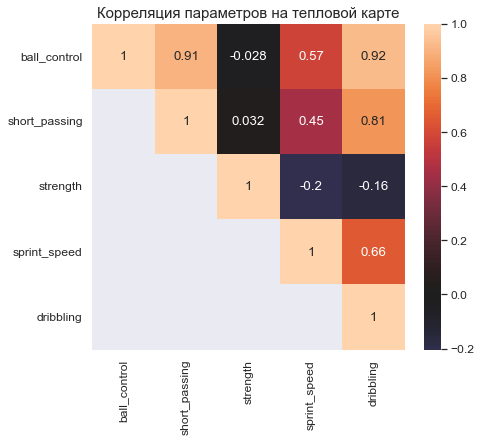

In [53]:
# # your code here
correlation_matrix = df[cols].corr()
display(correlation_matrix)

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) - 1
sns.heatmap(correlation_matrix, mask=mask, annot=True, center=0)
plt.title("Корреляция параметров на тепловой карте", fontsize=15);

* what can you say about selected feature set using this correlation matrix?

*****
### `КОММЕНТАРИЙ`

### Можно выделить несколько групп параметров, по тому как они коррелируют между собой:
**Группа 1**. Сильная корреляция:
* `ball_control`-`dribbling`
* `ball_control`-`short_passing`

**Группа 2**. Значительная корреляция:
* `short_passing`-`dribbling`

**Группа 3**. Заметная корреляция:
* `sprint_speed`-`dribbling`
* `sprint_speed`-`ball_control`

**Группа 4**. Малая положительная корреляция:
* `sprint_speed`-`short_passing`

**Группа 5**. Практически отсутствующая кореляция:
* ... все остальные


Таким образом, мы видим, что присутствуют параметры, которые необходимо далее узучать из-за их тесной взимосвязи.
*****


#### Let's build pairplots for features and target

* `plot_kws` parameter accepts dictionary of keyword arguments 
  that are passed to bivariate plotting function (`sns.scatterplot` in this case)


* we set size to 7 (using `s` parameter) to make points smaller and see patterns clearly.<br>
  you can compare this to running with not `plot_kws` passed.
  

* `alpha` parameter also helps to see data distribution clearly


* you can also experiment with `kind` parameter - refer to
  [seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
  documentation for possible values.

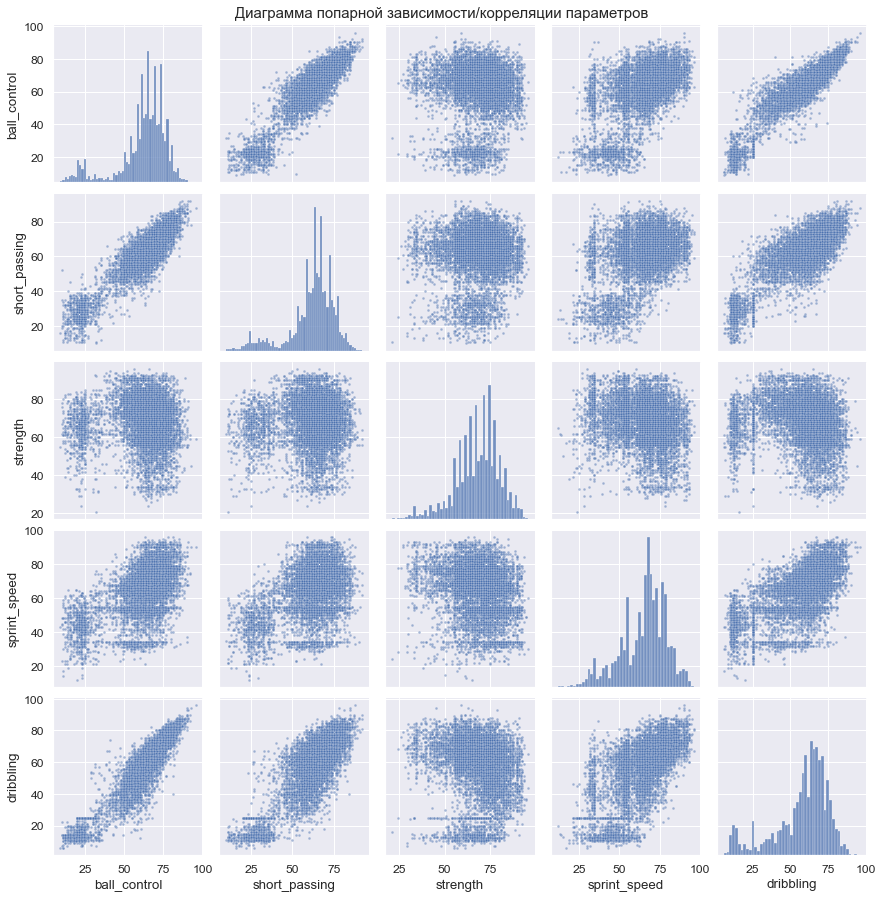

In [54]:
g = sns.pairplot(DF_TRAIN[cols], plot_kws={'s': 7, 'alpha': 0.5})
g.fig.suptitle("Диаграмма попарной зависимости/корреляции параметров", fontsize=15, y=1);


* what can you say about these scatterplots? is there anything we can use later?

*****
### `КОММЕНТАРИЙ`
**Первое**, что бросается в глаза - это то, что между отдельными параметрами просматривается зависимость, напоминающая линейную.

**Второе**: параметры с зависимостью близкой к линейной - это параметры, которые в соответтсвии с рассмотренной выше корреляционной матрицей имеют наиболее выраженную зависимость, то есть это **Группа 1** и **Группа 2**.

**Группа 3** и **Группа 4**  имеют уже значительно менее выраженную, но всё же отдалённо напоминающую линейную зависимость.

Видимо, при рассмотрении кореляционной матрицы не было причин делить на большое количество групп - группы можно укрупнить.
*****


 ### Solve using `sklearn`

In [55]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

*****
### `КОММЕНТАРИЙ`
На основании обучающих данных сформирована модель линейной регрессии.
*****


* explore fitted model parameters

In [56]:
model_intercept = model.intercept_
model_coef = model.coef_
print(f'model_intercept: {model_intercept}')
print(f'model_coef: {model_coef}')

model_intercept: -4.4107609944965205
model_coef: [ 0.98220522 -0.03927767 -0.14440889  0.20772844]


* how to interpret these model parameters?

*****
### `КОММЕНТАРИЙ`
Так же как и для двумерной модели (где линия определялась формулой **`Y = A * X + B`**), здесь в многомерной модели у нас "линией" будет являться многомерная плоскость. Для неё используется чуть более сложная формула, чем для двумерной прямой:

$ {Y}
= A_1 \cdot X_1 + A_2 \cdot X_2 + ... + A_n \cdot X_n + B
$

где:
* $n+1$ - полная размерность пространства;
* $B$ = model_intercept
* $A_i$ = model_coef[$i-1$]

Интерпретировать эти коэффициенты можно следующим образом:
* $B$ = смещение плоскости относительно начала координат многомерного пространства;
* $A_i$ = коэффициент, определяющий наклон плоскости относительно $i$-ой оси координат (из списка $X_1...X_n$)
*****


* use fitted model to get predictions for test set

In [57]:
model_preds = model.predict(x_test)
model_preds

array([44.30711902, 61.5246943 , 56.23794497, ..., 64.14903371,
       57.22105591, 75.15698321])

*****
### `КОММЕНТАРИЙ`
В предыдущей ячейке по тестовым данным с использованием полученной модели были сформированы предсказания.
*****


* explore model quality on test set.

In [58]:
print('model metrics on test set')
metrics_test_2 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_2

model metrics on test set


mse     38.192447
mae      4.459334
mape     0.112574
r2       0.887719
dtype: float64

*****
### `КОММЕНТАРИЙ`

### Проинтерпретируем значения метрик (выше), полученные с примерением предсказательной модели на тестовой выборке.

#### MSE: mean squared error (среднеквадратическая ошибка)
В формуле для MSE квадраты остатков в числителе взяты по той причине, чтобы плюсы и минусы не взаимоуничтожились. Физического смысла MSE не имеет, но чем ближе к нулю, тем модель лучше.

#### MAE: mean absolute error (средний модуль отклонения или )
Метрика измеряет среднюю сумму абсолютной разницы между фактическим значением и прогнозируемым значением. То есть в нашем случае в среднем ошибка модели "скачет" на +/- 4.46.

#### MAPE: mean percentage absolute error (средняя абсолютная ошибка в процентах - что бы перевести в % надо умножить на 100)
В нашем случае означает, что модель в среднем может ошибаться на 11,3%

#### R2: coefficient of determination (коэффициент детерминации)
Характеризует степень сходства исходных данных и предсказанных. В отличие от MSE не зависит от единиц измерения данных, поэтому поддается сравнению. Коэффициент детерминации — важный критерий выбора модели. И если модель плохо коррелирует с исходными данными, она вряд ли будет иметь высокую предсказательную силу.

Если использовать метрики MAE и MAPE для сравнения с предыдущей моделью, то можно сделать вывод, что эта модель лучше.
*****


* Let's compare `metrics_test_2` against `metrics_test_1`

In [59]:
# combine 2 series in 1 dataframe
metrics_comparison = metrics_test_1.to_frame('LR_1v').join(metrics_test_2.rename('LR_mv')).T
metrics_comparison

mse       mae      mape        r2
LR_1v  108.345801  8.173553  0.205500  0.681477
LR_mv   38.192447  4.459334  0.112574  0.887719

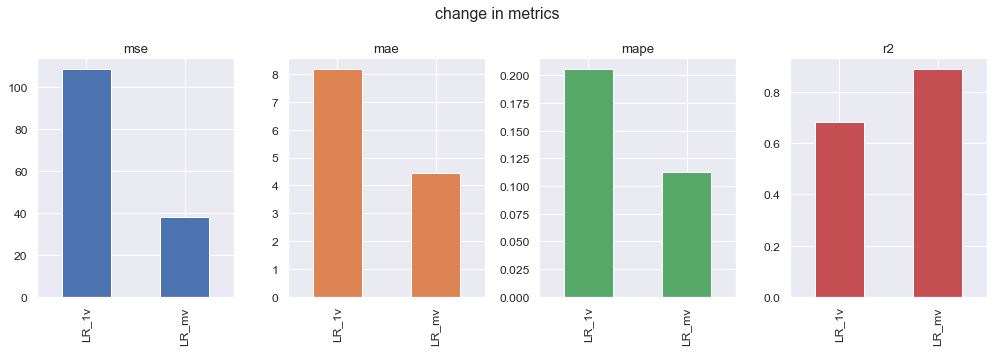

In [60]:
fig, ax = plt.subplots(figsize=(14, 5))  # specify figure size
metrics_comparison.plot(
    kind='bar', layout=(1,4), subplots=True, 
    title='change in metrics', legend=False, ax=ax
);
fig.tight_layout();  # prettify subplots. read more in documentation if interested

* did our Linear regression model improve after we've added more features?

*****
### `КОММЕНТАРИЙ`
Следует отметить:
* Как уже было сказано выше, если использовать метрики `MAE` и `MAPE` для сравнения с предыдущей моделью, то можно сделать вывод, что вторая предсказательная модель лучше. Но необходимо отметить, что использование MAE для сравнения моделей с разными размерностями (характиристиками), скорее всего не корректно, так как модели имеют разные размерности и, возможно разные единицы измерения по разным осям.
* Использовать `MSE` разных моделей для их сравнения, на мой взгляд так же не корректно - это метрика для оптимизации конкретной модели, а не для сравнения моделей разных размерностей.
* А вот `R2` характеризует степень сходства исходных данных и предсказанных и в отличие от `MSE` не зависит от единиц измерения данных, поэтому поддается сравнению. Коэффициент детерминации — важный критерий выбора модели. И если модель плохо коррелирует с исходными данными, она вряд ли будет иметь высокую предсказательную силу. Для приемлемых моделей предполагается, что коэффициент детерминации должен быть хотя бы не меньше 50 % (в этом случае коэффициент множественной корреляции превышает по модулю 70 %). Модели с коэффициентом детерминации выше 80 % можно признать достаточно хорошими (коэффициент корреляции превышает 90 %). **С нашим объёмом знаний можно скзать, что этот критерий подтверждает, что вторая модель лучне чем первая**. Но (**!!!**) "*Основная проблема применения `R2` заключается в том, что его значение* *увеличивается (не уменьшается) от добавления в модель новых переменных, даже если эти переменные никакого отношения к объясняемой переменной не имеют!* *Поэтому сравнение моделей с разным количеством факторов с помощью коэффициента детерминации, вообще говоря, некорректно.*" (https://ru.wikipedia.org/wiki/Коэффициент_детерминации)
*****


### Task 9. Implement Linear regression model with multiple variables yourself (5 points)

Okay, we've fitted Linear regression model using `sklearn` library. Now let's do the math ourselves!

### Prerequisites

For this task you will need to:
* have basic understanding of Linear algebra (operations with vectors and matrices)
* know how to perform matrix multiplication, transposition and inversion using `numpy` 
  (these functions can be found in NumPy documentation)
* carefully read the theory below and refer to wiki / textbooks / other sources if required

---

### Theory and notation

When we extend Linear regression model on case with $m$ variables we get the following formula:

* $ \hat{y}
= 1 \cdot w_0 + x_1 \cdot w_1 + x_2 \cdot w_2 + ... + x_m \cdot w_m
= \sum_{i=0}^{m} x_i w_i
$,

where:
* $x = (1, x_1, ..., x_m)$ is an _(m+1)_-element feature vector. 
    * $x_0 = 1$ is a special term introduced in the beginning of feature vector 
      to add intercept to Linear regression model
    * $x_i, i=\overline{1,m}$ is an _i_-th feature value.
* $w = (w_0, w_1, ..., w_m)$ is an _(m+1)_-element parameter vector
    * $w_0$ - the first value of parameter vector - is referred to as **intercept**
* $\hat{y}$ is a predicted value

----

The formula above is used to calculate predictions for 1 sample.
i.e. we predict 1 scalar $\hat{y}$ from 1 feature vector $x$.

If we have a dataset of $n$ samples $(x, y)$ - we get a system of linear equations:

$
\begin{cases}
 \hat{y}^{(0)} = \sum_{i=0}^{m} x_i^{(0)} w_i \\
 \hat{y}^{(1)} = \sum_{i=0}^{m} x_i^{(1)} w_i \\
 ... \\\
 \hat{y}^{(n-1)} = \sum_{i=0}^{m} x_i^{(n-1)} w_i
\end{cases}
$

Such system can be rewritten in a succinct matrix form (a way that we write equations in Linear algebra):

* $ \hat{y} = X \cdot w $

And the task of minimizing Residual sum of squares (RSS) now looks:
* $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = \|y - X \cdot w \|_2^2 \rightarrow min $

Here:
* $y = (y^{(0)}, y^{(1)}, ..., y^{(n-1)})$ now denotes a **vector of target values** we want to predict<br>
  $y^{(j)}$ is a target value for _j_-th sample in a dataset.
* $\hat{y} = (\hat{y}^{(0)}, ..., \hat{y}^{(n-1)})$ 
  now denotes a **vector of predictions** <br>
  $\hat{y}^{(j)}$ denotes a predicted value for _j_-th sample in a dataset
* $X$ is a **feature matrix** of shape $n \times (m+1)$. <br>
  _n_ rows correspond to _n_ data samples and _m+1_ columns correspond to _m+1_ features that describe each sample.
* $w = (w_0, w_1, ..., w_m)$ is still a **model parameter vector**
* $X \cdot w$ denotes a **matrix-by-vector** multiplication
* $\|\cdot\|_2$ denotes an $L_2$-norm and is basically a square root of sum of squares of vector elements:<br>
  $\|a\|_2 = \sqrt{a_0^2 + a_1^2 + ... + a_{n-1}^2}$ for an _n_-component vector _a_.
  Thus, RSS means the same as before:<br>
  $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = 
  (y^{(0)} - \hat{y}^{(0)})^2 + (y^{(1)} - \hat{y}^{(1)})^2 + ... + (y^{(n-1)} - \hat{y}^{(n-1)})^2 = 
  \sum_{j=0}^{n-1} (y^{(j)} - \hat{y}^{(j)})^2
  $

Note:
* we now use **superscripts** $\hat{y}^{(i)}$ instead of **subscripts** $\hat{y}_i$ as before
  to denote _i_-th sample in a dataset
* it is done to be able to refer both to sample index (denoted by superscript)
  and feature index (denoted by subscript) in a single equation. 
  
  Thus:
  * $x^{(j)} = (1, x^{(j)}_1, x^{(j)}_2, ..., x^{(j)}_{m})$  now denotes 
    _j_-th feature vector in a dataset with _m+1_ features
  * $x_i^{(j)}$ denotes an _i_-th feature value of _j_-th feature vector
  * $X = 
  \begin{bmatrix}
      1 & x^{(0)}_1 & x^{(0)}_2 & ... & x^{(0)}_{m} \\
      1 & x^{(1)}_1 & x^{(1)}_2 & ... & x^{(1)}_{m} \\
      ... \\
      1 & x^{(n-1)}_1 & x^{(n-1)}_2 & ... & x^{(n-1)}_{m}
    \end{bmatrix}
    $ is an $n \times (m+1)$ feature matrix. <br><br>
    $X$ can also be written as a column-vector of feature vectors:<br><br>
    $ X = \begin{bmatrix}x^{(0)} \\ x^{(1)} \\ ... \\ x^{(n-1)}\end{bmatrix} $

---

### Fit 

Enough notation! How can we fit this model?

By minimizin Residual sum of squares (RSS) for a Linear regression equation in a matrix form
we now get a **single** formula to find **all model parameters**!
* $ w = (X^T X)^{-1} X^T y $

Beautiful, isn't it? <br>
Recall, how we got individual formulas for $w_0, w_1$ in case of Linear regression with 1 predictor.<br>
Now we can find the whole parameter vector _w_ at once!

In the formula above:
* $X$ is an $n \times (m+1)$ dimensional feature matrix


* $X^T$ is a **transposed** feature matrix.<br>
  Transposition is a mathematical operation of "swapping" matrix dimensions.<br>
  So $X^T$ is an $(m+1) \times n$ dimensional matrix  


* $ (X^T X)^{-1} $ is the inverse matrix of $ X^T X $

Notes:
* Because of inversion operation performed on $X^T X$ matrix 
  there are difficulties in fitting Linear regression model in some cases.
  
  We will talk more on that later in the assignment.

---
    
If you want to learn more you can refer to 
[Linear least squares](https://en.wikipedia.org/wiki/Linear_least_squares)
wiki-page.

### Implementation

* implement `LRMatrixForm` class and `add_ones_column` function.<br>
  docstrings describe what each function/method should do - so read the docstrings.
  
  
* [what is a docstring?](https://www.python.org/dev/peps/pep-0257/#what-is-a-docstring)


Note:
* `LRMatrixForm` class must support 2 modes: **with** fitting intercept parameter and **without**.<br>
  The behavior is controlled by `fit_intercept` parameter passed to class constructor.

In [61]:
from sklearn.exceptions import NotFittedError

In [62]:
def add_ones_column(x):
    """ 
    Add column consisting of ones to the beginning of matrix `x`. 
    Used when fitting `LRMatrixForm` with `fit_intercept` param set to True.
    """
    # HINTS: 
    # * create a vector that consists of ones: (1, 1, ..., 1)
    # * then use either `np.column_stack` or `np.hstack` function to add this vector to a matrix
    
    # # your code here:
    ones_array = np.ones(x.shape[0])
    return (np.column_stack( (ones_array, x) ))

class LRMatrixForm:
    """
    Class that encapsulates Linear regression model with multiplie variables.
    Calculations are performed using matrix formula.
    
    Use `fit()` method to fit the model on data.
    Use `predict()` method to calculate predictions when the model is fitted.
    """
    def __init__(self, fit_intercept: bool = True):
        """
        fit_intercept: 
        Whether to calculate the intercept for this model. 
        If set to False, no intercept will be used in calculations 
        (i.e. data is expected to be centered).
        """
        self.fit_intercept = fit_intercept
        self.w_ = None  # vector with all model parameters (intercept and weights)
    
    def fit(self, x_train: pd.DataFrame, y_train: pd.Series):
        X = x_train.to_numpy()  # convert pd.DataFrame to numpy matrix
        Y = np.array(y_train)
        
        if self.fit_intercept is True:
            # when creating a model with intercept term we need to extend feature matrix
            # with a column consisting of ones (1, 1, ..., 1).
            X = add_ones_column(X)
            
        # # your code here to calculate model parameters:
        self.w_ = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
        
    @property
    def coef_(self):
        """ Property that returns model parameters without the intercept term. """
        if self.w_ is None:
            raise NotFittedError()
        # # your code here:
        if self.fit_intercept is True:
            return self.w_[1:]
        else:
            return self.w_
    
    @property
    def intercept_(self):
        """ Property that returns intercept term from model parameters. """
        if self.fit_intercept is not True:
            return 0.0  # for compatibility with sklearn
        if self.w_ is None:
            raise NotFittedError()
        # # your code here:
        w0 = self.w_[0]
        return w0
    
    def predict(self, x_test: pd.DataFrame):
        """ Generate predictions using fitted model parameters. """
        if self.w_ is None:
            raise NotFittedError()
        
        X = x_test.to_numpy()  # convert pd.DataFrame to numpy matrix
        
        if self.fit_intercept is True:
            X = add_ones_column(X)
            
        # # your code here to calculate predictions
        Y_predict = np.sum(X * self.w_, axis=1)
        return Y_predict

*****
### `КОММЕНТАРИЙ`
Класс реализован по выше представленным формулам.
*****


### Validate your implementation is identical to library version

In [63]:
lr_matrix_form = LRMatrixForm(fit_intercept=True)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  37.744076  4.423665  0.109928  0.879145
test   38.192447  4.459334  0.112574  0.887719

In [64]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: -4.410760994493857
coef: [ 0.98220522 -0.03927767 -0.14440889  0.20772844]


*****
### `КОММЕНТАРИЙ`
Так же как с одномерной линейной моделью, получены параметры для многомерной.
*****


In [65]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

*****
### `КОММЕНТАРИЙ`
... и эти параметры проходят необходимую проверку.
*****


* let's take a look at difference between model predictions and target values:

In [66]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean       -0.000265
std         6.181464
min       -19.832055
25%        -3.624840
50%        -0.929033
75%         2.657819
max        39.721074
Name: dribbling, dtype: float64

*****
### `КОММЕНТАРИЙ`
По представленному перечню статистик можем увидеть особенности сформированный линейной модели: в среднем (mean) отклонение не большое, но в отдельно взятых случаях они значительные (min и max).

Где-то выше мы уже выводили параметры для `LinearRegression`. Повторим их здесь ещё раз, чтобы можно было наглядно сравнить с моделью, которую получили на самостоятельно реализованном классе (`LRMatrixForm`):
*****


In [67]:
lr_matrix_form = LinearRegression(fit_intercept=True)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  37.744076  4.423665  0.109928  0.879145
test   38.192447  4.459334  0.112574  0.887719

*****
### `КОММЕНТАРИЙ`
Можно удостовериться (используя `fit_intercept=True`), что параметры, полученные при использовании `LinearRegression` и параметры модели, которую мы сделали самостоятельно (`LRMatrixForm`) **совпадают** с точностью до 6 знака после запятой.
*****


### Now let's compare `sklearn` model and yours with `fit_intercept=False`

In [68]:
model = LinearRegression(fit_intercept=False)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  38.001048  4.462836  0.111262  0.878322
test   38.417697  4.494385  0.114204  0.887057

In [69]:
lr_matrix_form = LRMatrixForm(fit_intercept=False)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  38.001048  4.462836  0.111262  0.878322
test   38.417697  4.494385  0.114204  0.887057

*****
### `КОММЕНТАРИЙ`
Можно удостовериться (используя `fit_intercept=False`), что параметры, полученные при использовании `LinearRegression` и параметры модели, которую мы сделали самостоятельно (`LRMatrixForm`) **совпадают** с точностью до 6 знака после запятой.
*****


* Compare the metrics on a test set of a model fitted **with** intercept parameter 
  vs model fitted **without** intercept.
* Which model has a better performance? Can you explain why?

*****
### `КОММЕНТАРИЙ`
Мы видим, что все метрики для случая `with intercept parameter` выглядят лучше чем `without intercept`.

**Объяснить это можно следующим образом**: если мы не используем параметр `intercept`, то мы фактически вносим некоторое ограничение в формулу плоскости многомерного пространства, а именно, исключаем параметр, который отвечает за смещение плоскости относительно центра координат. Как следствие, возникает ограничение в возможности оптимизировать модель, что влечёт за собой её "огрубление".
*****


In [70]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: 0.0
coef: [ 0.99382995 -0.05758452 -0.17865978  0.18315944]


In [71]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

* let's take a look at difference between model predictions and target values again:

In [72]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean        0.069583
std         6.199275
min       -20.437460
25%        -3.706841
50%        -0.888994
75%         2.766454
max        39.316868
Name: dribbling, dtype: float64

* compare this to the same statistics obtained with model fitted **with intercept**
* notice how the _mean_ value of difference changed

*****
### `КОММЕНТАРИЙ`
Сравнивая случаи `with intercept parameter` и `without intercept` видим что произошли некоторые изменения в статистиках. Наиболее заметно изменилось `среднее` (`mean`). Можно сказать, что модель линейной регрессия оптимизирует сумму расстояний до всех точек. В этом случае наиболее оптимальное расположение регрессионной линии (многомерной плоскости) приводит к тому, что `среднее` (`mean`) стремится к нулю. Стоит только внести условия, которые "ограничивают возможности" регрессионной линии (в нашем случае это `intercept=False`), то это приводит к тому, что "оптимальную" линию (многомерную плоскость) построить уже нельзя, точнее оптимизация становится ограниченной.
*****


## Limitations of Linear regression

Recall the formula to find Linear regression parameters in case of multiple variables:
* $ w = (X^T X)^{-1} X^T y $

As noted above, there might be difficulties with fitting Linear regression model
because of inverting $X^T X$ matrix.

Not every matrix can be inverted.

An example of such case is when 2 or more features have strong linear relationship between them.<br>
It means that one of variables can be **linearly predicted from the others with a substantial degree of accuracy**.<br>
Such situation is named **collinearitry** (in case of 2 related variables)
or **multicollinearity** (>2 related features).<br>

Collinearity is associated with high value of correlation coefficient between 2 related features.

You can refer to [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) 
wiki page to read more.

The intuition why multicollinearity is bad is that Linear Regression tries to capture 
a contribution of each individual feature to target independently of other features.
This is not possible with the data that has collinear features, 
as change in one such variable is always associated with change in other/others.

There are a whole bunch of really interesting thoughts that can help you 
to capture the intuition behind the concept of multicollinearity.<br>
You can find some of them 
[here](https://stats.stackexchange.com/questions/1149/is-there-an-intuitive-explanation-why-multicollinearity-is-a-problem-in-linear-r).

### Collinearity

* Let's construct and add a new feature to our dataset that is going to be _collinear_ with another one:

In [73]:
# select features as usual
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

In [74]:
def add_collinear_column(_df: pd.DataFrame, orig_col: str, new_col: str):    
    """ 
    Construct new column as a linear transform of another one + tiny noise.
    y = f(x) = a1 * x + a2 + noise.
    
    Alternatively, we could apply no linear transform at all (set a1=1, a2=0)
    And only add some noise to existing column. Results would be the same.
    """
    # linear transform
    _df[new_col] = 2 * _df[orig_col] + 3
    # add tiny normal noise
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

orig_col = 'sprint_speed'
new_col = 'sprint_speed_2'
add_collinear_column(x_train, orig_col, new_col)
add_collinear_column(x_test, orig_col, new_col)
features.append(new_col)

In [75]:
corr_coef = np.corrcoef(x_train[orig_col], x_train[new_col])[0, 1]
print(f'correlation between {orig_col} and {new_col}: {corr_coef}')

correlation between sprint_speed and sprint_speed_2: 0.9999999999936002


* As expected, correlation coefficient between collinear features 
  (`sprint_speed` and `sprint_speed_2`) is close to 1.<br>
  Thus they are highly correlated.

In [76]:
# visualize sample of train data
check = x_train.sample(5).copy()
# add helper column to see how much noise was added
check['sprint_speed_2_wo_noise'] = 2 * check['sprint_speed'] + 3
check

ball_control  short_passing  strength  sprint_speed  sprint_speed_2  \
28613           71.0           70.0      70.0          82.0      166.999914   
51282           69.0           65.0      66.0          81.0      165.000031   
45669           52.0           56.0      75.0          54.0      110.999967   
128378          78.0           77.0      61.0          71.0      145.000030   
62836           72.0           65.0      74.0          76.0      155.000066   

        sprint_speed_2_wo_noise  
28613                     167.0  
51282                     165.0  
45669                     111.0  
128378                    145.0  
62836                     155.0

### let's fit a Linear Regression model on this feature set:

In [77]:
model = LinearRegression(fit_intercept=True)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  37.743567  4.423540  0.109929  0.879147
test   38.195045  4.459684  0.112587  0.887711

* Both train and test metrics look reasonable
* Now let's explore model params:

In [78]:
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

intercept: 675.0906068527204
coef: [0.9822192129921219, -0.03933277165447219, -0.1443980890760301, 453.209062311137, -226.50064834143924]


* Weights that correspond to `sprint_speed` and `sprint_speed_2` columns should have gone insanely high!


* That is not ok. Large weights and weights instability are the sign of 
    [**overfitting**](https://en.wikipedia.org/wiki/Overfitting).

    According to the definition, overfitting is:<br>
    "_the production of an analysis that corresponds too closely 
    or exactly to a particular set of data,<br>
    and may therefore fail to fit additional data 
    or predict future observations reliably_".
    
    
* But what does that mean? Let's try to generate predictions with our model.

### generate predictions using our fitted model

In [79]:
check = x_test.head(2).copy()
check[target] = y_test.head(2)
check['preds'] = model.predict(check[features])
check

ball_control  short_passing  strength  sprint_speed  sprint_speed_2  \
147541          51.0           60.0      68.0          52.0      106.999953   
147549          65.0           69.0      66.0          69.0      140.999967   

        dribbling      preds  
147541       49.0  44.317195  
147549       59.0  61.531907

In [80]:
get_metrics(y_true=check[target], y_pred=check['preds'])

mse     14.169608
mae      3.607356
mape     0.069241
r2       0.433216
dtype: float64

* predictions look good, right? 

*****
### `КОММЕНТАРИЙ`
Нет каких-то явных причин сомневаться результатах, глядя на полученные метрики.
*****


### but what if we change `sprint_speed` values a bit? let's add some small `delta`

In [81]:
delta = 1  # some small value
check['sprint_speed'] += delta
check['preds_2'] = model.predict(check[features])
check

ball_control  short_passing  strength  sprint_speed  sprint_speed_2  \
147541          51.0           60.0      68.0          53.0      106.999953   
147549          65.0           69.0      66.0          70.0      140.999967   

        dribbling      preds     preds_2  
147541       49.0  44.317195  497.526257  
147549       59.0  61.531907  514.740969

In [82]:
get_metrics(y_true=check[target], y_pred=check['preds_2'])

mse     204437.816954
mae        452.133613
mape         8.439010
r2       -8176.512678
dtype: float64

* Wow, new predictions doesn't look even close to the target!<br>
  Our model doesn't look like a good model anymore.
  

* That is exactly what overfitting is. <br>
  **We fail to obtain reasonable predictions when we apply our model on new data**.

### One might notice that we have changed only 1 of 2 collinear features
* Indeed, giant model weights that correspond to these 2 features, should cancel each one out<br>
  if relation between feature values stays the same.  

* Let's check this out.<br>
  We have performed following transform:<br>
  `sprint_speed_changed = sprint_speed + delta`<br>
  

* How should we change `sprint_speed_2` to match the same data distribution from train data?<br>
  
  Let's calculate (we will ignore the noise added):  
  `sprint_speed_2_changed - sprint_speed_2 = f(sprint_speed_changed) - f(sprint_speed) =`<br>
  `= a1 * sprint_speed_changed + a2 - (a1 * sprint_speed + a2) = a1 * delta`

In [83]:
# here we change the second of collinear features 
# using the same coefficient 
# that was used in linear transform in `add_collinear_column()` function.
# we don't need to add intercept coefficient as it cancels it out (you can do the math yourself).
check['sprint_speed_2'] += 2 * delta
check['preds_3'] = model.predict(check[features])
check

ball_control  short_passing  strength  sprint_speed  sprint_speed_2  \
147541          51.0           60.0      68.0          53.0      108.999953   
147549          65.0           69.0      66.0          70.0      142.999967   

        dribbling      preds     preds_2    preds_3  
147541       49.0  44.317195  497.526257  44.524960  
147549       59.0  61.531907  514.740969  61.739672

* In the last example we see that new predictions (`preds_3`) now look similar to the first ones <br>
  (`preds` - calculated before changing `sprint_speed` value)


* So, if values of collinear features change accordingly - we are safe, right? <br>
  How do your think, can we always rely on this assumtion?

*****
### `КОММЕНТАРИЙ`
На основании только одного примера мы не можем полагаться, что во всех остальных случаях ситуация будет такой же.
*****


### What just happened

* The answer to the question above is: **no, we can't**.
  
  
* Yes, we have checked that if collinear features values are changed accordingly 
  (i.e. their **initial relation is preserved**), <br>
  model predictions look reasonable and accurate.
  
  But this will not always be the case on the real data.
  
  We can't be sure that the data 
  that we apply our fitted model on (`x_test`, for example)<br>
  preserves **exactly the same data distribution** as the data that model was trained on (`x_train`).
  
  

**Why this happened?**

* When feature matrix contains collinear or multicollinear features (the problem of **multicollinearity**),
  inversion of such a matrix is numerically unstable.<br>
  This leads to large values and imprecise estimates of model parameters.

**How to detect multicollinearity**
* You should monitor your model weights. For example using $L_2$ norm:<br>
  $ L_2(w) = \|w\|_2 = \sqrt{w_1^2 + w_2^2 + ... + w_n^2} = \sqrt{\sum_{i=1}^{n} w_i^2} $<br>
  If any of model weights are huge - $L_2$ norm will also have large value.
  
  
* Monitor model performance on validation data. 
  If the metrics are poor and prediction look huge,<br>
  you should check if collinear features are present in train data.

**How to fix the issue**

* For each set of collinear features, keep only 1 of them and remove the rest.<br>
  The best regression models are those in which the predictor variables each correlate highly 
  with the target variable,<br>
  but correlate at most only minimally with each other.
  

* Combine collinear features into new ones

  
* Use regularization (will be covered later in the course).

### Task 10. Implement function to calculate $L_2$-norm. (1 point)
* Use formula above to implement $L_2$ norm

In [84]:
def l2_norm(arr: Iterable):
    # your code here
    return np.sqrt(np.sum(np.square(arr)))
    

*****
### `КОММЕНТАРИЙ`
Функция, расчитывающая значение метрики $L_2$-norm готова.
*****


### Calculate $L_2$-norm value for current model
* you should get high value that represents large values of some model parameters

In [85]:
l2_norm(model.coef_)

506.6576605682478

*****
### `КОММЕНТАРИЙ`
Действительно получили большое значение, используя метрику $L_2$-norm, что я вляется признаком линейной зависимости столцов.
*****


### Multicollinearity
  
* It's important to notice that in case of multicollinearity,
  correlation coefficient between each pair of related variables
  could be **not so high**.
  
  So **it may be hard to find multicollinear features in your data**.
  

* Let's visualize it in practice.

  We will build a new feature that has a strong linear relationship with 2 other features:
  $x_1 = a_0 + a_2 x_2 + a_3 x_3 + noise$

  We want to show that Linear regression model will still suffer from multicollinearity,<br>
  but correlation coefficients betweent each pair of multicollinear features will be **less close to 1**
  than it was in case of collinearity.

In [86]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

def add_collinear_column(_df: pd.DataFrame, col1: str, col2: str, new_col: str):    
    _df[new_col] = _df[col1] + _df[col2] + 5
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

add_collinear_column(x_train, col1='sprint_speed', col2='strength', new_col='foo')
add_collinear_column(x_test, col1='sprint_speed', col2='strength', new_col='foo')
features.append(new_col)

model = LinearRegression(fit_intercept=True)
m = fit_and_evaluate(model, x_train, y_train, x_test, y_test)
display(m)
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

mse       mae      mape        r2
train  37.740149  4.424104  0.109933  0.879158
test   38.212005  4.461402  0.112679  0.887661

intercept: -3131.4201177100567
coef: [0.9822478449802048, -0.03937156569597123, -625.5463829795605, -625.1941087977586, 625.4019263207153]


* As before, model parameters for multicollinear features should be large

* Let's calculate $L_2$-norm value - it should also be large

In [87]:
l2_norm(model.coef_)

1083.1918051484904

*****
### `КОММЕНТАРИЙ`
Действительно для случая мультиколлинеарности, отдельные веса (коэффициенты) не так сильно велики, как это было в предыдущем случае. Но используя метрику $L_2$-norm, в этом конкретном случае мы опять получем большое значение.
*****


#### Task 11. Visualize correlation matrix for `x_train`  (1 point)
* Build annotated heatmap (use `annot` param to add values to plot, select diverging `cmap` and center it at 0)
* You should see that `foo` feature is correlated with ones it was created from,<br>
  but each of these correlation coefficients **is not so close to 1**

In [88]:
# your code here
x_train.corr()

ball_control  short_passing  strength  sprint_speed       foo
ball_control       1.000000       0.904857 -0.024422      0.572677  0.474099
short_passing      0.904857       1.000000  0.039196      0.450801  0.415056
strength          -0.024422       0.039196  1.000000     -0.203386  0.541851
sprint_speed       0.572677       0.450801 -0.203386      1.000000  0.712702
foo                0.474099       0.415056  0.541851      0.712702  1.000000

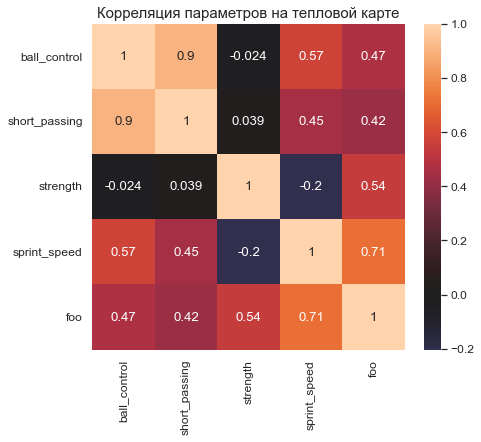

In [89]:
sns.heatmap(x_train.corr(), annot=True, center=0)
plt.title("Корреляция параметров на тепловой карте", fontsize=15);

*****
### `КОММЕНТАРИЙ`
Действительно, сгенерированный параметр `foo` визуально несильно коррелирует с прото-столбцами: `strength` и `sprint_speed`. Видим, что значения не сильно близки к 1.
*****


### Regularization

* The concept of regularization (that was mentioned above) is simple.

  We modify Loss function (RSS in case of Linear regression) in such a way<br>
  to penalize for large values of model parameters.
  
  
* $L_2$ regularization, also named as 
  [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization), 
  adds $L_2$ term to loss function:

  $L(w,x,y) = RSS(w,y) + \alpha L_2(w) = \|y - \hat{y}\|_2^2 + \alpha \|w\|_2^2 
  = \|y - X \cdot w \|_2^2 + \alpha \|w\|_2^2$
  
  parameter $ \alpha \ge 0 $ controls the ammount of regularization applied
  

* Linear regression implemented with $L_2$ regularization is named a **Ridge regression**.


* Ridge regression is implemented in `Ridge` class in `sklearn` library

---

Let's see how applying regularization changes our model.

In [90]:
from sklearn.linear_model import Ridge

* at first fit `Ridge` without any regularization to ensure we get similar results 
  to using `LinearRegression`

In [91]:
# `solver` parameters determines the algorithm used to solve regression task.
# we fix it to be `svd` to achieve desired results.
model_r = Ridge(alpha=0, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  37.740149  4.424104  0.109933  0.879158
test   38.212005  4.461402  0.112679  0.887661

In [92]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: -3131.420117710042
coef: [0.9822478449802052, -0.03937156569589423, -625.5463829795615, -625.1941087977593, 625.401926320716]
l2 norm: 1083.1918051484918


* some model parameters should be large, as well as the $L_2$-norm value
* now, let's add some regularization

In [93]:
model_r = Ridge(alpha=0.01, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  37.744053  4.423665  0.109928  0.879145
test   38.192492  4.459339  0.112574  0.887719

In [94]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: -13.349041617119532
coef: [0.9822052987292079, -0.03927790627124068, -1.932064815819428, -1.5799270891866755, 1.787655806670947]
l2 norm: 3.2235116481207853


* notice how parameter values changed
* also notice how $L_2$-norm values decreased

## Task 12. Putting all together. (up to 10 points)

In the final task we'll try to recap all that we have learnt so far.

Your task is to build a Linear regression model with multiple variables to predict `agility` variable.<br>
Only `LinearRegression` class is allowed to be used for modeling.<br>

Steps you need to follow:

* Make a new train/test split with new proportion: 70% on train and 30% on test data **(1 point)**


* Fit a model **(up to 6 points)**
    
    * Choose >= 10 features from training set as initial set of features
      Explain your choice. **(1 point)**
      
    * Visualize correlation matrix for selected features **(1 point)**
    
    * Analyze if collinear/multicollinear features are present in your feature set.<br>
      Process collinear/multicollinear features if they are present:<br>
      remove redundant features, combine features into new ones, etc **(up to 3 points)**
     
    * Fit the model and calculate metrics on train and test sets<br>
      **(1 point max. -0.25 points per each metric that was not implemented in the beginning of the assignment)**
    

* Analyze fitted model performance **(up to 2 points)**:
    * Print fitted model parameters and calculate their $L_2$-norm value **(1 point)**
    * Make conclusion whether your model overfitted or not. Provide your arguments. **(1 point)**


* Write a short report about the work done **(1 point)**<br>
  Can you find a logical explanation for high correlation of some of your features?<br>
  Are you satisfied with the quality of predictions?<br>
  How could you pottentially improve the model?<br>
  Any other thoughts.


**Penalties:**
- **0 points are assigned for the whole task** if used a model different from:
    - `sklearn.linear_model.LinearRegression`
    - or `LRMatrixForm`

*****
### `КОММЕНТАРИЙ`
Создадим новое разделение данных с новой пропорцией: 70% для тренировочного датасета  и 30% для тестовых данных.
*****


In [95]:
ix_split = int(0.7 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(f"Исходный размер: {df.shape} \nТренировочный датасет: {DF_TRAIN.shape[0]} \nТестовые данные: {DF_TEST.shape[0]}")
print(f"({DF_TRAIN.shape[0]} + {DF_TEST.shape[0]} = {DF_TRAIN.shape[0] + DF_TEST.shape[0]})")

Исходный размер: (10582, 35) 
Тренировочный датасет: 7407 
Тестовые данные: 3175
(7407 + 3175 = 10582)


*****
### `КОММЕНТАРИЙ`
Необходимо сделать выбор параметров (не менее 10 шт), которые будем использоваться для постороения модели. Выберем 12 штук - с запасом.

Воспользуемся корреляционной матрицей и выберем те параметры, которые больше всего коррелируют с целевым параметром (`agility`).
*****

In [96]:
correlation_matrix = df.corr()
correlation_matrix = correlation_matrix[["agility"]]
correlation_matrix = correlation_matrix[correlation_matrix.index != "agility"]
correlation_matrix = correlation_matrix.sort_values(by="agility", ascending=False).head(12)

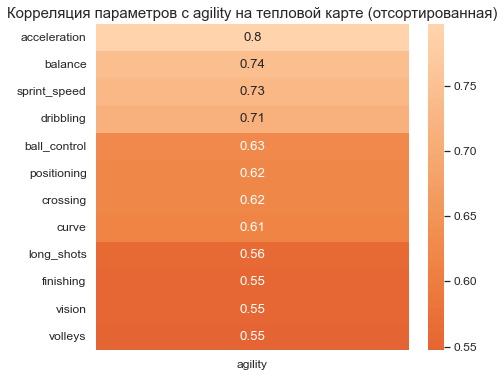

In [97]:
sns.heatmap(correlation_matrix, annot=True, center=0)
plt.title("Корреляция параметров с agility на тепловой карте (отсортированная)", fontsize=15);

*****
### `КОММЕНТАРИЙ`
Посмотрим на кореляцию выбранных параметров.
*****

In [98]:
target = 'agility'
features = list(correlation_matrix.index)
x_train, y_train, x_test, y_test = get_train_test_data(features, target)
cols = features + [target]
cols

['acceleration',
 'balance',
 'sprint_speed',
 'dribbling',
 'ball_control',
 'positioning',
 'crossing',
 'curve',
 'long_shots',
 'finishing',
 'vision',
 'volleys',
 'agility']

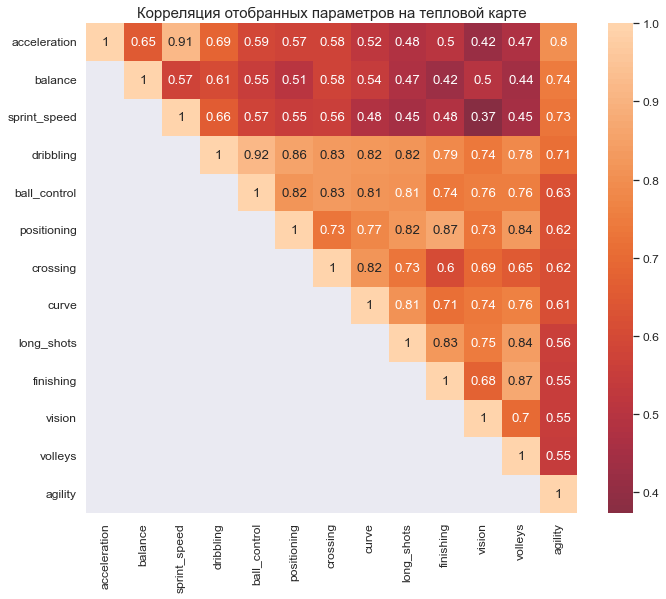

In [99]:
correlation_matrix = df[cols].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) - 1
plt.figure(figsize=(11, 9))
sns.heatmap(correlation_matrix, mask=mask, annot=True, center=0)
plt.title("Корреляция отобранных параметров на тепловой карте", fontsize=15);

*****
### `КОММЕНТАРИЙ`
Видим, что зависимость между параметрами сильно отличается от паре к паре.
*****

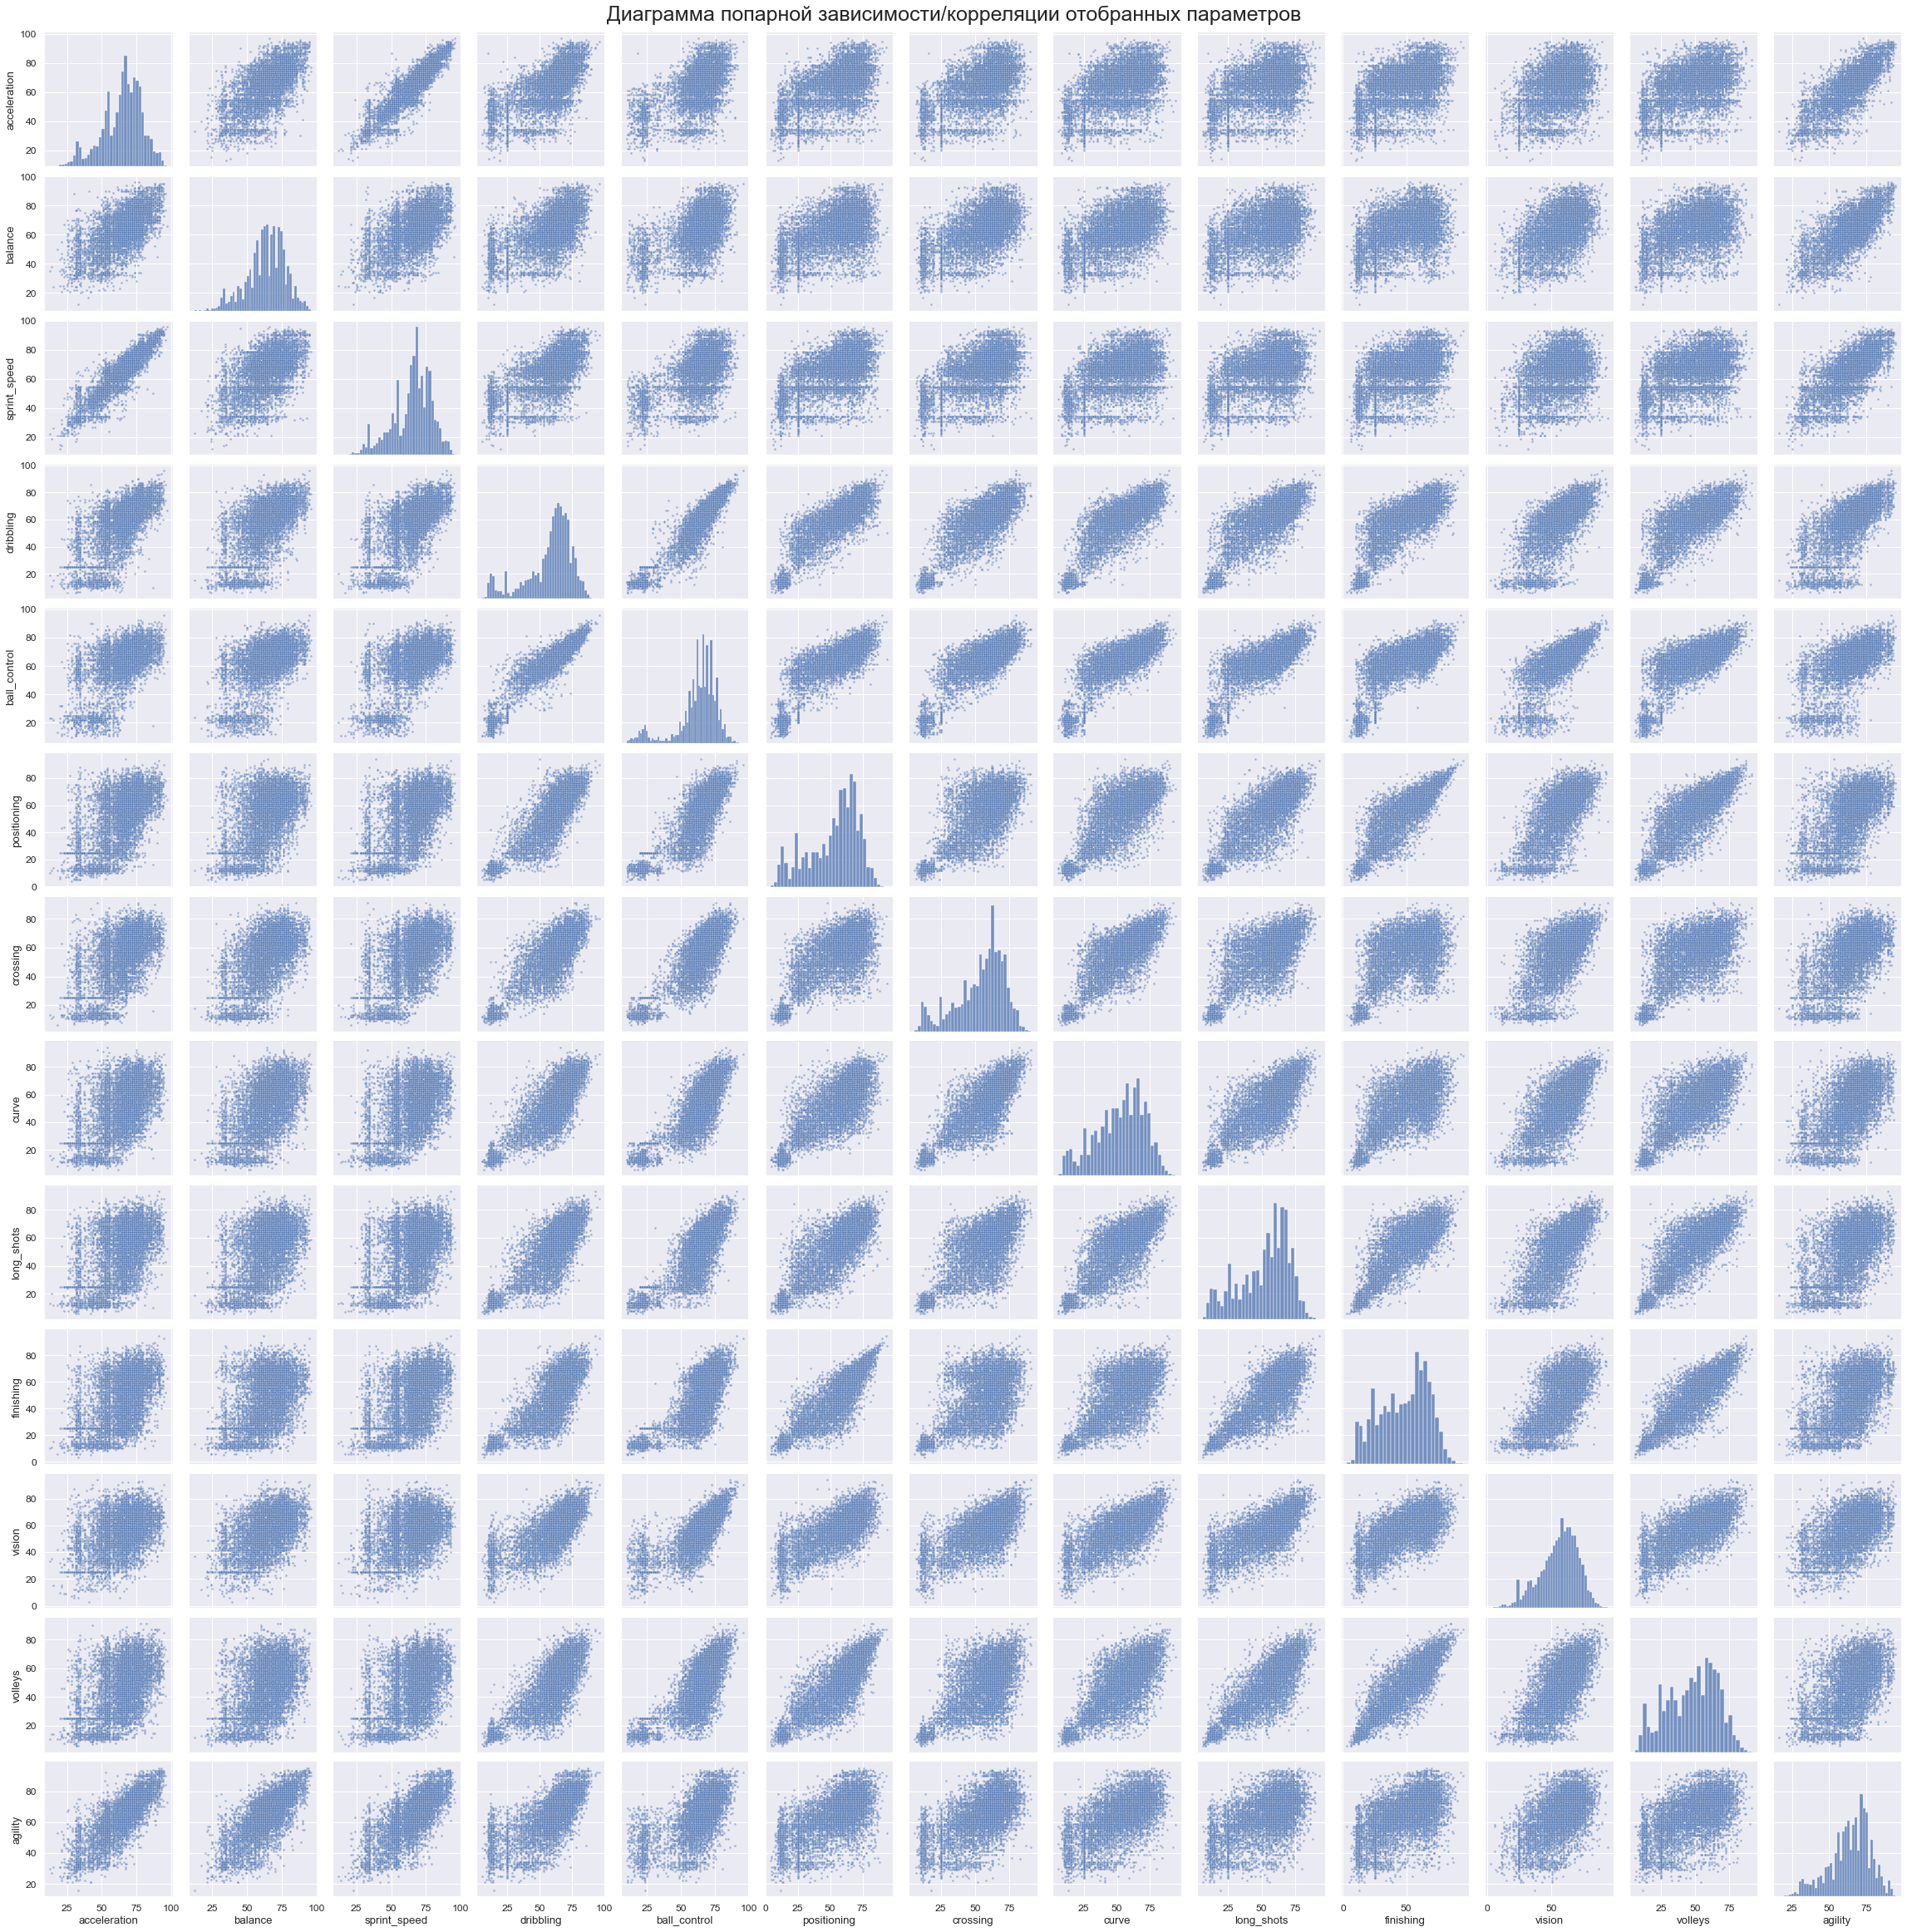

In [100]:
g = sns.pairplot(DF_TRAIN[cols], plot_kws={'s': 7, 'alpha': 0.5})
g.fig.suptitle("Диаграмма попарной зависимости/корреляции отобранных параметров", fontsize=25, y=1);

*****
### `КОММЕНТАРИЙ`
Для того чтобы определить присутствуют или нет взаимозависимые параметры (коллинеарные или мультиколлинеарные) подготовим и оценим метрику: $L_2$-norm.
*****

In [101]:
lr_matrix_form = LRMatrixForm(fit_intercept=True)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  45.433566  5.132219  0.091576  0.757663
test   49.641267  5.289752  0.095410  0.748391

In [102]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: 4.816675200070018
coef: [ 0.39898903  0.31320973  0.061506    0.13660468 -0.10846714  0.01264084
 -0.03555281  0.07783424 -0.02663192  0.0106739   0.1052966   0.01080229]


In [103]:
l2_norm(lr_matrix_form.coef_)

0.5576833740857896

*****
### `КОММЕНТАРИЙ`
В наличии следующие данные, позволяющие сделать вывод о налиичии или об отсутствии линейной зависимости между параметрами модели:
* корреляция между отдельными параметрами не достигает значений близких к 1;
* значение метрики $L_2$-norm маленькое (меньше 1).  
Используя эти данные, делаем вывод, что, скорее всего, параметров с сильной линейной зависимостью нет.

Таким образом:
* **Было выбрано 12 параметров** (
`acceleration`, 
`balance`, 
`sprint_speed`, 
`dribbling`, 
`ball_control`, 
`positioning`, 
`crossing`, 
`curve`, 
`long_shots`, 
`finishing`, 
`vision`, 
`volleys`) для формирования модели для прогнозирования целевого параметра `agility`. **Основанием для выбора указанных параметров явилось то, что это параметры с наибольшей корреляцией к целевому параметру, но при этом корреляция между самими параметра не является исключиетльно большой (не очень близка к 1)**, что соответствут подсказке, данной выше: `"The best regression models are those in which the predictor variables each correlate highly with the target variable, but correlate at most only minimally with each other."`.
* **Визуализирована корреляционная матрица** для параметров, на основании которых сформирована модель.
* **Обсчитана модель и расчитаны метрики на обучающем и тестовом датасетах**.
* **Проанализировано и выявлено отсутствие коллинеарных и мультиколлинеарных параметров**, что говорит об отсутствии необходимости проводить с ними какие-либо манипуляции (удаление или объединение).


Кроме этого:
* **Параметры сформированной модели логистической регрессии распечатаны и рассмотрены** и по этим параметрам модели **расчитано значение метрики $L_2$-norm**.
* Среди коэффициентов, соответствующих отдельным параметрам, нет больших значений, которые бы при незначительном изменении параметров приводили бы к значительным изменения предсказываемых значений (это можно проверить меняя по чуть-чуть каждый из параметрои и наблюдая как заметно меняется предсказание, но этого можно и не делать, потому что это и так следует из понимания формулы, по которой формируется предсказание в линейнорегрессионной моделе). **Это является признаком отсутствия переобученности (overfitting) модели**.
*****

*****
### `КРАТКИЙ ОТЧЁТ О ВЫПОЛНЕННОЙ РАБОТЕ`
### Общая информация о выполненной работе.
В рамках настоящей работы был рассмотрен и, на сколько это было возможно, изучен один из алгоритмов машинного обучения. Данный алгоритм является, наверное, самым простым как для изучения, так и для самостоятельной его реализации.

Мы рассмотрели и реализовали алгоритм в двух его вариантах – для двумерной модели (с одним параметром данных и целевой переменной) и для многомерной модели данных (n- параметров и целевая переменная).

Самостоятельно провели работу по отбору параметров для построения новой модели машинного обучения для прогнозирования поведения переменной `agility` и по анализу качества работы полученной модели. 

Итоговые выводы и оценки по данной модели были приведены выше.

По качеству выдаваемых результатов моделью есть вопросы и что обсудить. Рассмотрим их ниже.


### С чем связана высокая корреляционная зависимость некоторых параметров?
На корреляционной матрице мы видим, что некоторые параметры находятся в значительной корреляционной зависисмости. Такими парами параметров являются `acceleration`-`sprint_speed` и `dribbling`-`ball_control`, коэффициенты корреляции которых составляют `0.91` и `0.92` соответственно.

### Ниже на скриншоте диаграммы отмечены пары параметров с наибольшей корреляцией:

![Альтернативный текст](https://github.com/DIVIGL1/RSSchool-ML-Open-Course/blob/main/HiCorrFeatures.PNG?raw=true "параметры с высокой корреляцие.")


 Эту корреляцию можно объяснить логически, обратившись к определению (описанию) этих параметров в энциклопедии FIFA (https://www.fifplay.com/encyclopedia/):

#### `acceleration`-`sprint_speed`
* **`Acceleration`**: Ускорение — это Атрибут игрока в FIFA, определяющий приращение скорости бега игрока (спринтерская скорость) на поле. Скорость ускорения определяет, насколько быстро игрок может достичь максимальной скорости спринта (https://www.fifplay.com/encyclopedia/player-attribute-acceleration/).
* **`Sprint Speed`**: Спринтерская скорость — это атрибут игрока в FIFA, который определяет спринтерскую скорость игрока (https://www.fifplay.com/encyclopedia/player-attribute-sprint-speed/).  
 **Исходя из представленных определений видим, что эти два параметра по смыслу ОЧЕНЬ тесно связаны.**

#### `dribbling`-`ball_control`
* **`Dribbling`**: Дриблинг — это атрибут игрока в FIFA, который определяет способность игрока вести мяч и обходить соперника, сохраняя контроль (https://www.fifplay.com/encyclopedia/player-attribute-dribbling/).
* **`Ball control`**: Контроль мяча — это атрибут игрока в FIFA, который определяет способность игрока контролировать мяч на поле (https://www.fifplay.com/encyclopedia/player-attribute-ball-control/).  
 **Исходя из представленных определений видим, что эти два параметра так же ОЧЕНЬ тесно связаны по своему смысловому содержанию.**

### Качество прогнозов, выдаваемых полученной моделью линейной регрессии.
Сравнивая метрики, которые мы получили по данным первой (одномерной) и второй моделями, с метриками модели, сгенерированной по 12-ти параметрам (атрибутам игроков), мы обнаруживаем, что для последней модели:
* `mape` заметно лучше в сравнении с 1-ой моделью;
* `mape` немного лучше в сравнении со 2-ой моделью;
* `R2` лучше чем у 1-ой, но хуже чем у второй модели.  
Вспомним, что R2 - это coefficient of determination (коэффициент детерминации), который характеризует степень сходства исходных данных и предсказанных. В отличие от MSE не зависит от единиц измерения данных, поэтому поддаётся сравнению. Коэффициент детерминации — важный критерий выбора модели. И если модель плохо коррелирует с исходными данными, она вряд ли будет иметь высокую предсказательную силу. Таким образом, Заключение, которое можно сделать - это то, что прогнозы формируемые полученной моделью, скорее всего, должны быть лучше и над моделью необходимо ещё поработать, "настроив" её параметры и улучшив результаты по метрикам.


#### Что можно предложить для улучшения модели?
* Необходимо обратить внимание на параметры, которые коррелируют с целевой переменной ниже 0.7. Можно их исключить или  попытаться сформировать из них новые параметры, которые, возможно, будут иметь большую корреляцию с целевой переменной.
* Изучить влияние на прогноз параметров, которые мы изначально исключили из рассмотрения.
* Выбрать и применить другие модели машинного обучения.

### Прочее.
Рассмотрев данный алгоритм машинного обучения можно сделать ряд предположений/выводов:
* Модели линейной регрессии сравнительно просты и предлагают простые для понимания математические формулы прогнозирования. Линейная регрессия может применяться в разных областях науки и бизнеса.
* Линейная регрессия используется повсюду: в биологии, исследованиях поведения и окружающей среды, в обществознании и бизнесе. Модели линейной регрессии зарекомендовали себя в качестве надежного научного метода прогнозирования будущего. Поскольку линейная регрессия представляет собой хорошо изученную статистическую процедуру, свойства моделей линейной регрессии хорошо понятны и просты в обучении.
* Так как модель строится на данных, расположенны в определённом диапазоне, то и предсказывать значения она может только в рамках этого диапазона, то есть нет причин предполагать, что модель будет адекватно работать вне этого диапазона.

#### В Интеренете в отношении линейной регрессии дают следующие рекомендации:
(https://www.ibm.com/ru-ru/analytics/learn/linear-regression)

Прежде чем выполнять линейную регрессию, необходимо убедиться, что данные поддаются анализу этим методом. Данные должны соответствовать определенным допущениям. Как проверить выполнение этих допущений:

* Переменные должны измеряться непрерывно. Примеры непрерывных переменных: время, продажи, вес, результаты тестов. 
* С помощью диаграммы рассеяния можно быстро определить, имеется ли линейная взаимосвязь между двумя переменными.
* Наблюдения должны быть независимыми друг от друга.
* В данных не должно быть значительных выбросов.  
* Проверьте данные на гомоскедастичность — однородность дисперсии случайной ошибки регрессионной модели.
* Дисперсия случайной ошибки регрессионной модели должна иметь нормальное распределение.

*****